<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/OU_process_2D/Models/adapted_pinn_easy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports & FP64
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [2]:
# Problem & True Solution
R = 2.0
theta = 0.5
sigma = 1.0

def true_tau(x, y, theta=theta, sigma=sigma, R=R):
    lam = theta / sigma**2
    rho = np.sqrt(x**2 + y**2)
    integrand = lambda t: np.exp(lam * t**2) * special.gammainc(1, lam * t**2) / t
    I, _ = integrate.quad(integrand, rho, R)
    return I / theta

true_tau_vec = np.vectorize(true_tau)

In [3]:
# generating some approximate true solutions in the domain

#sampling anchor points, biased towards center (failure zone)
def sample_disk(batch_size, R, radius_frac=0.6):
    """
    Sample uniformly in the DISK of radius (radius_frac * R).
    This is the simplest way to concentrate points near the centre.
    """
    r = torch.sqrt(torch.rand(batch_size, device=device))  # uniform‐disk radius ∝ sqrt(U)
    theta = 2 * torch.pi * torch.rand(batch_size, device=device)
    x = torch.stack([r * torch.cos(theta), r * torch.sin(theta)], dim=1)
    return radius_frac * R * x  # now uniform in disk of radius radius_frac*R


# 2) monte-carlo (euler-maruyama) approximation of tau at these points
@torch.no_grad()
def mc_exit_time(x0, theta, sigma, R,
                 n_paths=128, dt=1e-3, max_steps=20000):
    """
    x0: [B,2] starting points
    Returns tau_hat: [B] = mean exit time from each x0.
    Any path still 'alive' after max_steps is counted as having exit time = max_steps*dt.
    """
    B = x0.shape[0]
    P = n_paths

    # Expand to per‐path positions
    X = x0.unsqueeze(1).expand(B, P, 2).clone()  # [B,P,2]
    t = torch.zeros(B, P, device=device)         # running clock
    alive = torch.ones(B, P, dtype=torch.bool, device=device)
    sqrt_dt = sigma * (dt ** 0.5)

    for step in range(max_steps):
        if not alive.any():
            break

        # Drift + noise, but only update those still alive
        X_alive = X[alive]
        drift    = -theta * X_alive * dt
        noise    = sqrt_dt * torch.randn_like(X_alive)
        X[alive] += drift + noise
        t[alive] += dt

        # Mark newly‐exited paths
        just_exited = (X[alive].pow(2).sum(dim=1) >= R*R)
        idx_alive   = alive.nonzero(as_tuple=False)  # [[i1,j1], [i2,j2], ...]
        exited_idx  = idx_alive[just_exited]
        alive[exited_idx[:,0], exited_idx[:,1]] = False

    # Paths still alive get t = max_steps*dt automatically from the loop
    tau_hat = t.mean(dim=1)  # [B]
    return tau_hat  # no gradient flows back

In [4]:
# Random Fourier Homotopy g(x) to regularize the forcing term
class RandomFourierHomotopy:
    def __init__(self, M=200, freq_scale=None, R=R, magnitude=5.0):
        """
        M           : number of random Fourier modes
        freq_scale  : base frequency scale (if None, defaults to π/R)
        R           : radius of the disk
        magnitude   : overall output scale
        """
        self.M         = M
        self.R         = R
        self.magnitude = magnitude

        if freq_scale is None:
            # pick a lower base frequency so the field is smooth
            freq_scale = math.pi / R

        # sample random directions & phases
        # omega: [M,2], b: [M], a: [M]
        self.omega = torch.randn(M, 2) * freq_scale
        self.b     = 2 * math.pi * torch.rand(M)
        # normalize by sqrt(M) so that raw variance ~1
        self.a     = torch.randn(M) / math.sqrt(M)

    def __call__(self, x):
        """
        x: [N,2] tensor of (x,y) points
        returns: [N] tensor of forcing values
        """
        # 1) compute raw random Fourier sum
        #    proj: [N,M] = x·omega^T + b
        proj  = x @ self.omega.t() + self.b
        g_raw = (self.a * torch.cos(proj)).sum(dim=1)    # [N]

        # 2) normalize to zero mean, unit std dev (over this batch)
        mean   = g_raw.mean()
        stddev = g_raw.std(unbiased=False).clamp(min=1e-6)
        g_norm = (g_raw - mean) / stddev                # [N]

        # 3) nonlinearity: tanh keeps it in (–1,1) but nonzero everywhere
        g_nl = torch.sigmoid(g_norm)                       # [N]

        # 4) radial mask to fade to zero at |x|=R
        r2   = (x**2).sum(dim=1)                        # [N]
        mask = ((self.R**2 - r2).clamp(min=0)
                / (2 * self.R))                       # [N]

        # 5) scale to the desired magnitude
        return self.magnitude * g_nl * mask             # [N]

In [5]:
# defining PINN w/ trainable dilation and matching boundary condition
class BoundaryPINN(nn.Module):
    def __init__(self, width=50, depth=3, power=2, R=R):
        super().__init__()
        self.R = R
        self.alpha = nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        layers = [nn.Linear(2, width)]
        for _ in range(depth):
            layers += [nn.ReLU(), nn.Linear(width, width)]
        layers[-1] = nn.Linear(width, 1)  # replace last act+lin with just lin
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        λ = torch.exp(self.alpha)
        out = self.net(x * λ).squeeze(-1)
        mask = ((self.R**2 - (x**2).sum(dim=1)).clamp(min=0)
                / (2*self.R))
        return out.pow(2) * mask

In [6]:
# defining PDE Residual & Loss, enabling grad on x
def pde_residual(model, x, theta, sigma, g_fn=None, nu=None):
    # ensure x is on the right device, float64, and requires grad
    x = x.clone().detach().to(device).requires_grad_(True)

    # forward through PINN
    tau = model(x)                                # [N]
    # first derivatives
    grads = torch.autograd.grad(
        tau, x,
        grad_outputs=torch.ones_like(tau),
        create_graph=True,
    )[0]                                        # [N,2]
    tau_x, tau_y = grads[:,0], grads[:,1]

    # second derivatives
    tau_xx = torch.autograd.grad(
        tau_x, x,
        grad_outputs=torch.ones_like(tau_x),
        create_graph=True
    )[0][:,0]
    tau_yy = torch.autograd.grad(
        tau_y, x,
        grad_outputs=torch.ones_like(tau_y),
        create_graph=True
    )[0][:,1]

    # OU‐generator L[tau]
    phys = -theta*(x[:,0]*tau_x + x[:,1]*tau_y) \
           + 0.5*sigma**2*(tau_xx + tau_yy)

    r = phys + 1.0                              # L[tau] + 1
    if g_fn is not None and nu is not None:
        r = r + g_fn(x)/nu
    return r

def loss_fn(res):
    return torch.mean(res.pow(2))

In [7]:
# defining Uniform + Adaptive Sampling functions in the disk
def sample_uniform_disk(N, R=R):
    theta = 2*np.pi * torch.rand(N, dtype=torch.float64, device=device)
    ρ = R    * torch.sqrt(torch.rand(N, dtype=torch.float64, device=device))
    return torch.stack([ρ*torch.cos(theta), ρ*torch.sin(theta)], dim=1)  # [N,2]

def make_adaptive_batch(
    model, pool_size, batch_size,
    g_fn, nu, theta, sigma,
    hard_frac=0.1,    # fraction of batch from highest residuals
    use_soft=False,   # if True, sample soft rather than top‐K
    beta=1.0          # exponent for soft sampling
):
    # candidate pool
    Xp = sample_uniform_disk(pool_size)

    # 2) Compute residuals _with_ gradient‐tracking so second‐derivatives work
    r_all = pde_residual(model, Xp, theta, sigma, g_fn, nu)  # [pool_size]
    # 3) Detach and take absolute
    Rvals = r_all.detach().abs()                             # [pool_size]

    # number of hard points
    K     = int(batch_size * hard_frac)
    if use_soft:
        # 2a) soft sampling: probabilities ∝ (residual^beta)
        weights = Rvals.pow(beta)
        weights = weights / (weights.sum() + 1e-12)
        hard_idx = torch.multinomial(weights,
                                     num_samples=K,
                                     replacement=False)
    else:
        # 2b) hard sampling: pure top‐K
        hard_idx = torch.topk(Rvals, K).indices # [K]

    all_idx  = torch.arange(pool_size, device=device)
    mask     = torch.ones(pool_size, dtype=torch.bool, device=device)
    mask[hard_idx] = False
    rest_idx = all_idx[mask]
    n_rest   = batch_size - K
    rnd      = rest_idx[torch.randperm(rest_idx.numel(), device=device)[:n_rest]]

    batch_idx = torch.cat([hard_idx, rnd], dim=0)                # [batch_size]
    return Xp[batch_idx]                                      # [batch_size,2]

In [8]:
# Training parameters
pool_size        = 4096
batch_size       = 512
n_epochs_per_nu  = 10_000
learning_rate    = 5e-2
nu_schedule      = 4 * [None]  # None -> pure PDE
beta = 0 #0 -> no adaptive sampling, infty -> top K sampling

model = BoundaryPINN().to(device)
g_hom = RandomFourierHomotopy(M=50)
opt   = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler: every `step_size` epochs multiply lr by gamma
step_size = 500        # decay every step_size epochs
gamma     = 0.85         # mutiply lr by gamma at each step
scheduler = torch.optim.lr_scheduler.StepLR(opt,
                                            step_size=step_size,
                                            gamma=gamma)

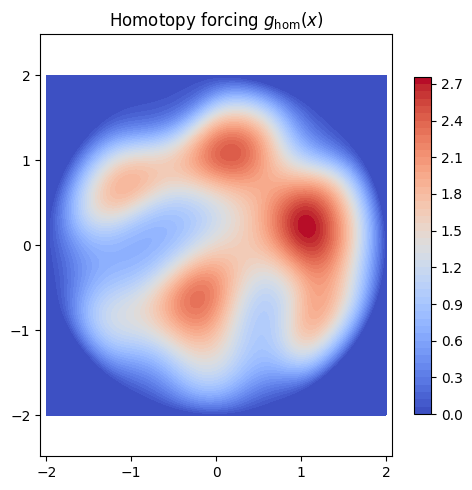

In [9]:
# plot homotopy forcing g_hom(x)
n_pts = 200
xx, yy = np.meshgrid(
    np.linspace(-R,R,n_pts),
    np.linspace(-R,R,n_pts)
)
mask = xx**2 + yy**2 <= R**2
grid_pts = np.vstack([xx[mask], yy[mask]]).T

with torch.no_grad():
    g_vals = g_hom(torch.from_numpy(grid_pts).to(device)).cpu().numpy()

Zg = np.zeros_like(xx)
Zg[mask] = g_vals

plt.figure(figsize=(5,5))
cg = plt.contourf(xx, yy, Zg, levels=50, cmap='coolwarm')
plt.colorbar(cg, shrink=0.8)
plt.title('Homotopy forcing $g_{\\rm hom}(x)$')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [10]:
# sample x_data
x_data = sample_disk(batch_size = batch_size,
                     R = R,
                     radius_frac = 0.6)

# precompute tau_data once (theta, sigma are fixed PDE params)
tau_data = mc_exit_time(
    x0       = x_data,
    theta    = theta,
    sigma    = sigma,
    R        = R,
    n_paths  = 256,
    dt       = 1e-3,
    max_steps= 10_000
)

data_penalty = 1.0 #weight of the data term in the loss function

In [11]:
# Training Loop w/ Homotopy & Loss Logging


# prep for best‐model tracking
best_loss       = float("inf")
best_model_path = "best_adam.pth"

total_history = {}
pde_history   = {}
data_history  = {}
global_epoch = 0

for nu in nu_schedule:
    name = f"nu={nu}" if nu is not None else "nu=∞"
    total_history[name] = []
    pde_history[name]   = []
    data_history[name]  = []

    print(f"\n=== Training with {name} ===")

    for ep in range(1, n_epochs_per_nu + 1):
        opt.zero_grad()

        # build one adaptive batch
        Xb = make_adaptive_batch(model, pool_size, batch_size,
                                 g_hom, nu, theta, sigma, beta = beta)  # [batch_size,2]

        # compute PDE‐residual on that batch
        r = pde_residual(model, Xb, theta, sigma, g_hom, nu)      # requires_grad=True
        loss_pde = loss_fn(r)

        # -- data‐loss on precomputed (x_data, tau_data)
        tau_pred = model(x_data).squeeze(-1)
        loss_data = (tau_pred - tau_data).pow(2).mean()

        # -- total
        loss_total = loss_pde + data_penalty * loss_data

        # — checkpoint if best
        if loss_total.item() < best_loss:
            best_loss = loss_total.item()
            torch.save(model.state_dict(), best_model_path)

        #backward + step
        loss_total.backward()
        opt.step()
        scheduler.step()

        #logging
        global_epoch += 1
        total_history[name].append( loss_total.item() )
        pde_history[name].append(   loss_pde.item()   )
        data_history[name].append(  loss_data.item()  )

        if ep % 100 == 0:
            print(f"  [{name}] epoch {ep:4d}  loss_pde {loss_pde:.2e}  loss_data {loss_data:.2e}")

        if global_epoch % 500 == 0:
            lr = scheduler.get_last_lr()[0]
            print(f"    → global_epoch {global_epoch:5d},   lr = {lr:.2e}")


=== Training with nu=∞ ===
  [nu=∞] epoch  100  loss_pde 5.31e-01  loss_data 7.22e-02
  [nu=∞] epoch  200  loss_pde 8.37e-01  loss_data 8.26e-02
  [nu=∞] epoch  300  loss_pde 1.13e+00  loss_data 1.75e-01
  [nu=∞] epoch  400  loss_pde 1.10e+00  loss_data 2.05e-01
  [nu=∞] epoch  500  loss_pde 9.94e-01  loss_data 1.58e-01
    → global_epoch   500,   lr = 4.25e-02
  [nu=∞] epoch  600  loss_pde 1.05e+00  loss_data 3.00e-01
  [nu=∞] epoch  700  loss_pde 1.08e+00  loss_data 2.96e-01
  [nu=∞] epoch  800  loss_pde 1.14e+00  loss_data 2.63e-01
  [nu=∞] epoch  900  loss_pde 9.98e-01  loss_data 3.36e-01
  [nu=∞] epoch 1000  loss_pde 1.16e+00  loss_data 2.07e-01
    → global_epoch  1000,   lr = 3.61e-02
  [nu=∞] epoch 1100  loss_pde 1.09e+00  loss_data 2.50e-01
  [nu=∞] epoch 1200  loss_pde 1.18e+00  loss_data 2.35e-01
  [nu=∞] epoch 1300  loss_pde 1.11e+00  loss_data 3.09e-01
  [nu=∞] epoch 1400  loss_pde 1.20e+00  loss_data 2.91e-01
  [nu=∞] epoch 1500  loss_pde 1.29e+00  loss_data 1.70e-01
   

In [12]:
#LBFGS fine-tuning

# Reload best Adam snapshot
print(f"\nLoading best Adam model (loss={best_loss:.2e}) …")
model.load_state_dict(torch.load(best_model_path))
model.to(device)


# define L-BFGS parameters
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50,
    history_size=10,
    tolerance_grad=1e-7,
    tolerance_change=1e-9,
    line_search_fn="strong_wolfe"
)

# freeze one big PDE batch for the closure
Xb_ft = make_adaptive_batch(
    model, pool_size, pool_size,
    g_hom, None, theta, sigma, beta=beta
).detach()

lbfgs_total = []
lbfgs_pde   = []
lbfgs_data  = []

#closure function
def closure():
    lbfgs.zero_grad()
    # PDE term
    r_ft    = pde_residual(model, Xb_ft, theta, sigma, g_hom, nu=None)
    pde_l   = loss_fn(r_ft)
    # data term
    tau_p   = model(x_data).squeeze(-1)
    data_l  = (tau_p - tau_data).pow(2).mean()
    total_l = pde_l + data_penalty * data_l

    # record
    lbfgs_total.append(total_l.item())
    lbfgs_pde.append(  pde_l.item()   )
    lbfgs_data.append( data_l.item()   )

    total_l.backward()
    return total_l



Loading best Adam model (loss=5.65e-01) …


In [14]:
# report losses before/after lbfgs
# make sure model is in eval mode so e.g. Dropout/BatchNorm won’t move
model.eval()

# --- PDE loss (needs grad to compute ∇u inside pde_residual) ---
r_before = pde_residual(model, Xb_ft, theta, sigma, g_hom, nu=None)
before_pde = loss_fn(r_before).item()

# --- data loss (pure forward, safe under no_grad) ---
with torch.no_grad():
    pred = model(x_data).squeeze(-1)
    before_data = (pred - tau_data).pow(2).mean().item()

print(f"Before L-BFGS → PDE {before_pde:.2e}, DATA {before_data:.2e}")

# … run your L-BFGS …

# after L-BFGS, same pattern:
model.eval()
r_after = pde_residual(model, Xb_ft, theta, sigma, g_hom, nu=None)
after_pde = loss_fn(r_after).item()
with torch.no_grad():
    pred = model(x_data).squeeze(-1)
    after_data = (pred - tau_data).pow(2).mean().item()
print(f" After L-BFGS → PDE {after_pde:.2e}, DATA {after_data:.2e}")

Before L-BFGS → PDE 3.58e-01, DATA 6.79e-02
 After L-BFGS → PDE 3.58e-01, DATA 6.79e-02


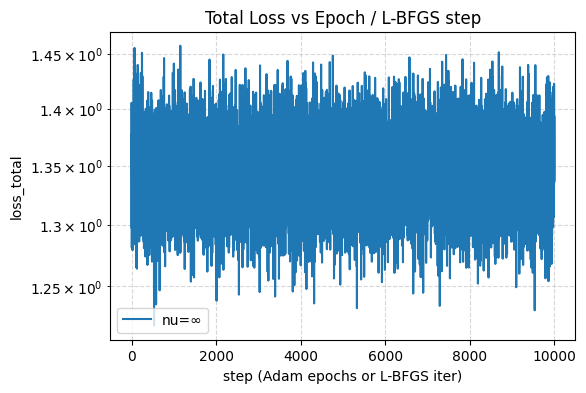

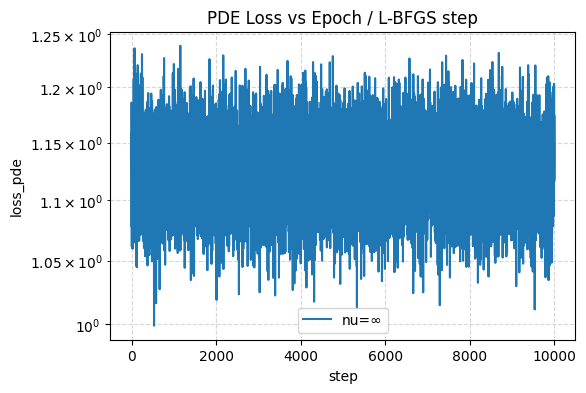

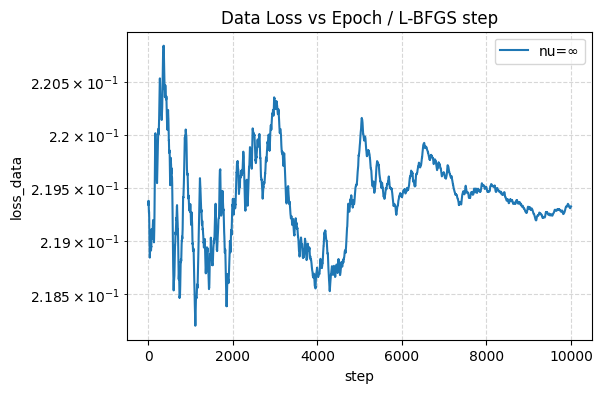

In [15]:
# Plotting three separate loss evolutions
# a) Total Loss
plt.figure(figsize=(6,4))
for name, arr in total_history.items():
    plt.semilogy(arr, label=name)
plt.title("Total Loss vs Epoch / L-BFGS step")
plt.xlabel("step (Adam epochs or L-BFGS iter)")
plt.ylabel("loss_total")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# b) PDE Loss
plt.figure(figsize=(6,4))
for name, arr in pde_history.items():
    plt.semilogy(arr, label=name)
plt.title("PDE Loss vs Epoch / L-BFGS step")
plt.xlabel("step")
plt.ylabel("loss_pde")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# c) Data Loss
plt.figure(figsize=(6,4))
for name, arr in data_history.items():
    plt.semilogy(arr, label=name)
plt.title("Data Loss vs Epoch / L-BFGS step")
plt.xlabel("step")
plt.ylabel("loss_data")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

plt.show()

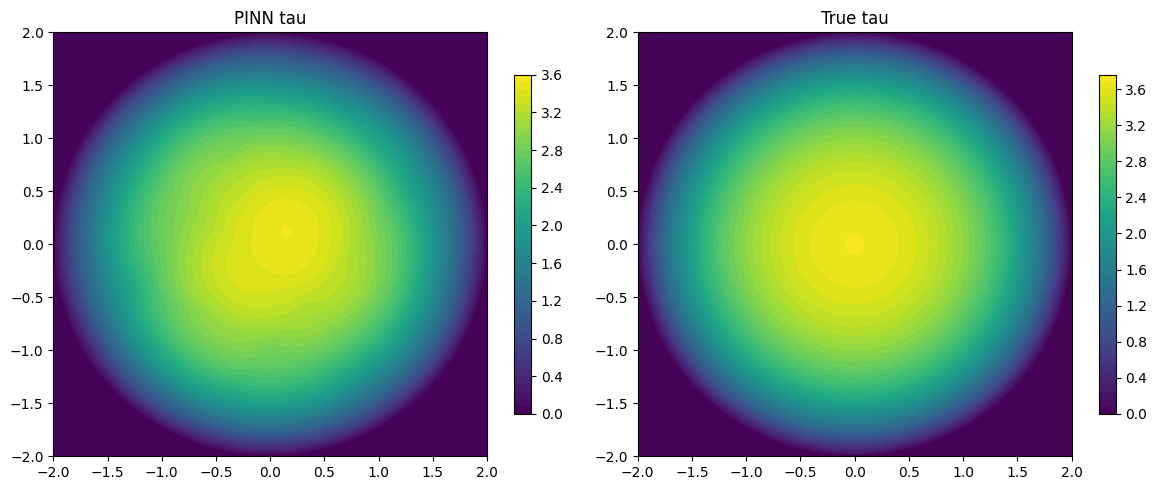

In [16]:
# 9) Visualize PINN vs True tau
n_pts = 200
xx, yy = np.meshgrid(
    np.linspace(-R,R,n_pts),
    np.linspace(-R,R,n_pts)
)
mask = xx**2 + yy**2 <= R**2
pts = np.vstack([xx[mask], yy[mask]]).T

with torch.no_grad():
    inp = torch.from_numpy(pts).to(device)
    pred = model(inp).cpu().numpy()

Zp = np.zeros_like(xx); Zt = np.zeros_like(xx)
Zp[mask], Zt[mask] = pred, true_tau_vec(xx[mask], yy[mask])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
cf1 = ax1.contourf(xx, yy, Zp, levels=50, cmap='viridis')
ax1.set_title('PINN tau')
fig.colorbar(cf1, ax=ax1, shrink=0.8)

cf2 = ax2.contourf(xx, yy, Zt, levels=50, cmap='viridis')
ax2.set_title('True tau')
fig.colorbar(cf2, ax=ax2, shrink=0.8)
plt.tight_layout()
plt.show()

Global relative L2 error: 8.974e-02


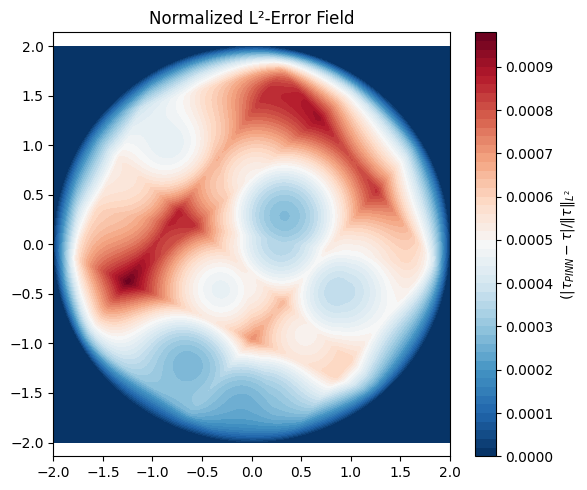

In [17]:
# average relative L2 error
#    ‖tau_pinn − tau_true‖₂ / ‖tau_true‖₂
pred_vals = pred
true_vals = true_tau_vec(pts[:,0], pts[:,1])
tau_l2_norm =  np.linalg.norm(true_vals)
glob_rel_L2 = np.linalg.norm(pred_vals - true_vals) / tau_l2_norm
print(f"Global relative L2 error: {glob_rel_L2:.3e}")

# pointwise relative L2 error
Z_err = np.abs(Zp - Zt)                     # raw error
Z_err_norm = Z_err / tau_l2_norm
#err_flat = Z_err[mask]              # flatten to disk
#L2_norm = np.sqrt(np.mean(err_flat**2))
#Z_err_norm = np.zeros_like(Z_err)
#Z_err_norm[mask] = Z_err[mask] / L2_norm

plt.figure(figsize=(6,5))
cf = plt.contourf(xx, yy, Z_err_norm, levels=50, cmap='RdBu_r')
plt.colorbar(cf, label=r'$(|\tau_{PINN}-\tau|/\|\tau\|_{L^2}$')
plt.title('Normalized L²‐Error Field')
plt.axis('equal')
plt.tight_layout()
plt.show()